In [96]:
from tqdm.notebook import tqdm
import numpy as np
from dppy.beta_ensembles import HermiteEnsemble

def sample_gap_small_Gaussian(n, beta, sigma, repeats):
    ndiff = n-1
    res = np.empty((repeats * ndiff,))

    for i in tqdm(range(repeats), leave = False): 
        hermite = HermiteEnsemble(beta=beta)
        eigvals = hermite.sample_banded_model(loc=0.0, scale = 1.0, size_N=n)
        eigvals.sort()
        gaps = np.diff(eigvals) / np.sqrt(beta)
        res[i*ndiff:(i+1)*ndiff] = gaps

    return sigma * res

def sample_dynamic_Gaussian_unormalized(N  : int,
                            mu : float,
                            D  : float,
                            t  : float,
                            beta : int, 
                            repeats : int):
    ndiff = N-1
    if mu != 0:
        var = np.repeat(np.sqrt(D * (1 - np.exp(-2 * mu * t))/(mu * beta)) , ndiff)
    else:
        var = np.repeat(np.sqrt(2 * D * t / beta) , ndiff)
    gap = sample_gap_small_Gaussian(N, beta, 1, repeats)
    gap = gap * var
    return gap

def sample_reset_Gaussian_unormalized(r  : float,
                     N  : int,
                     mu : float,
                     D  : float,
                     beta : int,
                     repeats : int):
    tau = np.random.exponential(scale = 1/r, size=(repeats,))
    return sample_dynamic_Gaussian_unormalized(N, mu, D, tau, beta, repeats)

R = 2.4572
MU = 4.14543
BETA = 6.548123
D = 5.1423043

gaps = sample_reset_Gaussian_unormalized(r = R, N = 2, mu = MU, D = D, beta = BETA, repeats=int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

/var/folders/sz/cm6xc5q95j11zxlg5rh30pn40000gq/T/ipykernel_69908/704773799.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return prefactor * np.array([ integrate.quad(lambda u : integrand(u, zi), 0, np.inf)[0] for zi in z])


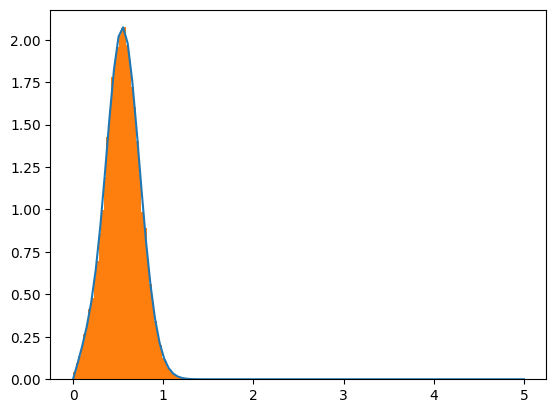

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.special import gamma as G

xtab = np.linspace(0, 5, 100)

def reset_gaps(z, gamma, beta):
    prefactor = z**beta/(2 **beta * G((1 + beta)/2))
    def integrand(u, zi):
        return np.exp(-u) * (1/(1 - np.exp(-2 * gamma * u)))**((1 + beta)/2) * np.exp(-zi**2/(4 * (1 - np.exp(-2 * gamma * u))))
    return prefactor * np.array([ integrate.quad(lambda u : integrand(u, zi), 0, np.inf)[0] for zi in z])

GAMMA = MU / R

SCALE = np.sqrt(MU * BETA**2 / (D))

plt.plot(xtab, SCALE * reset_gaps(SCALE * xtab, GAMMA, BETA))

plt.hist(gaps, density=True, bins = 50)

plt.show()

In [70]:
from dppy.beta_ensembles import HermiteEnsemble

hermite = HermiteEnsemble(beta=BETA)

gaps = []
for _ in range(100000):
    x1, x2 = hermite.sample_banded_model(loc=0.0, scale = 1, size_N=2)
    gaps.append(np.abs(x1 - x2) / np.sqrt(BETA) )

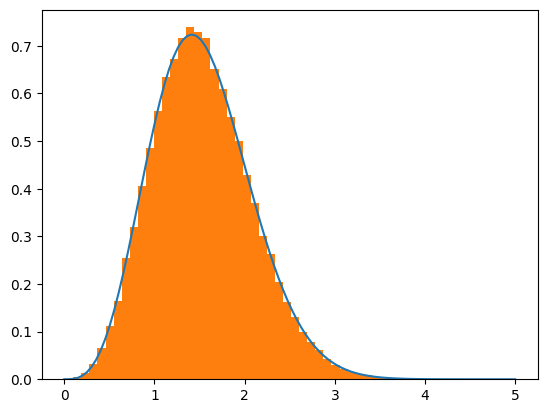

In [71]:
xtab = np.linspace(0, 5, 100)

def rho(x, beta):
    sigma = 1
    return 1/(2 ** beta * G((1 + beta)/2)) * np.sqrt(beta/sigma**2) * (x * np.sqrt(beta / sigma**2))**beta * np.exp(-x**2 * beta / (4 * sigma**2))

plt.plot(xtab, rho(xtab, BETA))
plt.hist(gaps, density= True, bins = 50)
plt.show()